## 1. Read SST Reanalysis
You can download ERSST Reanalysis & Korea station data on below URL : 

URL : https://www.dropbox.com/sh/nbt8zer5r0yex92/AAAVw-MYUggHOBwCWbzUGKrWa?dl=0

In [1]:
## Modules for Calculate netCDF 
import numpy    as np
import xarray   as xr
import netCDF4 
import pandas as pd

## Modules for caculating statistics
from scipy   import stats, signal
from sklearn import linear_model

## Modules for plottings
import matplotlib.pyplot as plt 
import matplotlib.colorbar as cb
from mpl_toolkits.basemap import Basemap, shiftgrid

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

## Modules for modulating systems
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
f = xr.open_dataset("./DJF_nino34.nc")
nino34 = f["DJFnino34"]

f = xr.open_dataset("./anom_SST.nc")
anom_SST = f["anom_SST"]
lon =  f["lon"].values
lat =  f["lat"].values

In [3]:
## Specify the range of lat, lon and time of SST data
latS = -90.      ;   latN = 90.
lonL = 0.        ;   lonR = 360.
yr_str = 1979    ;   yr_end = 2018

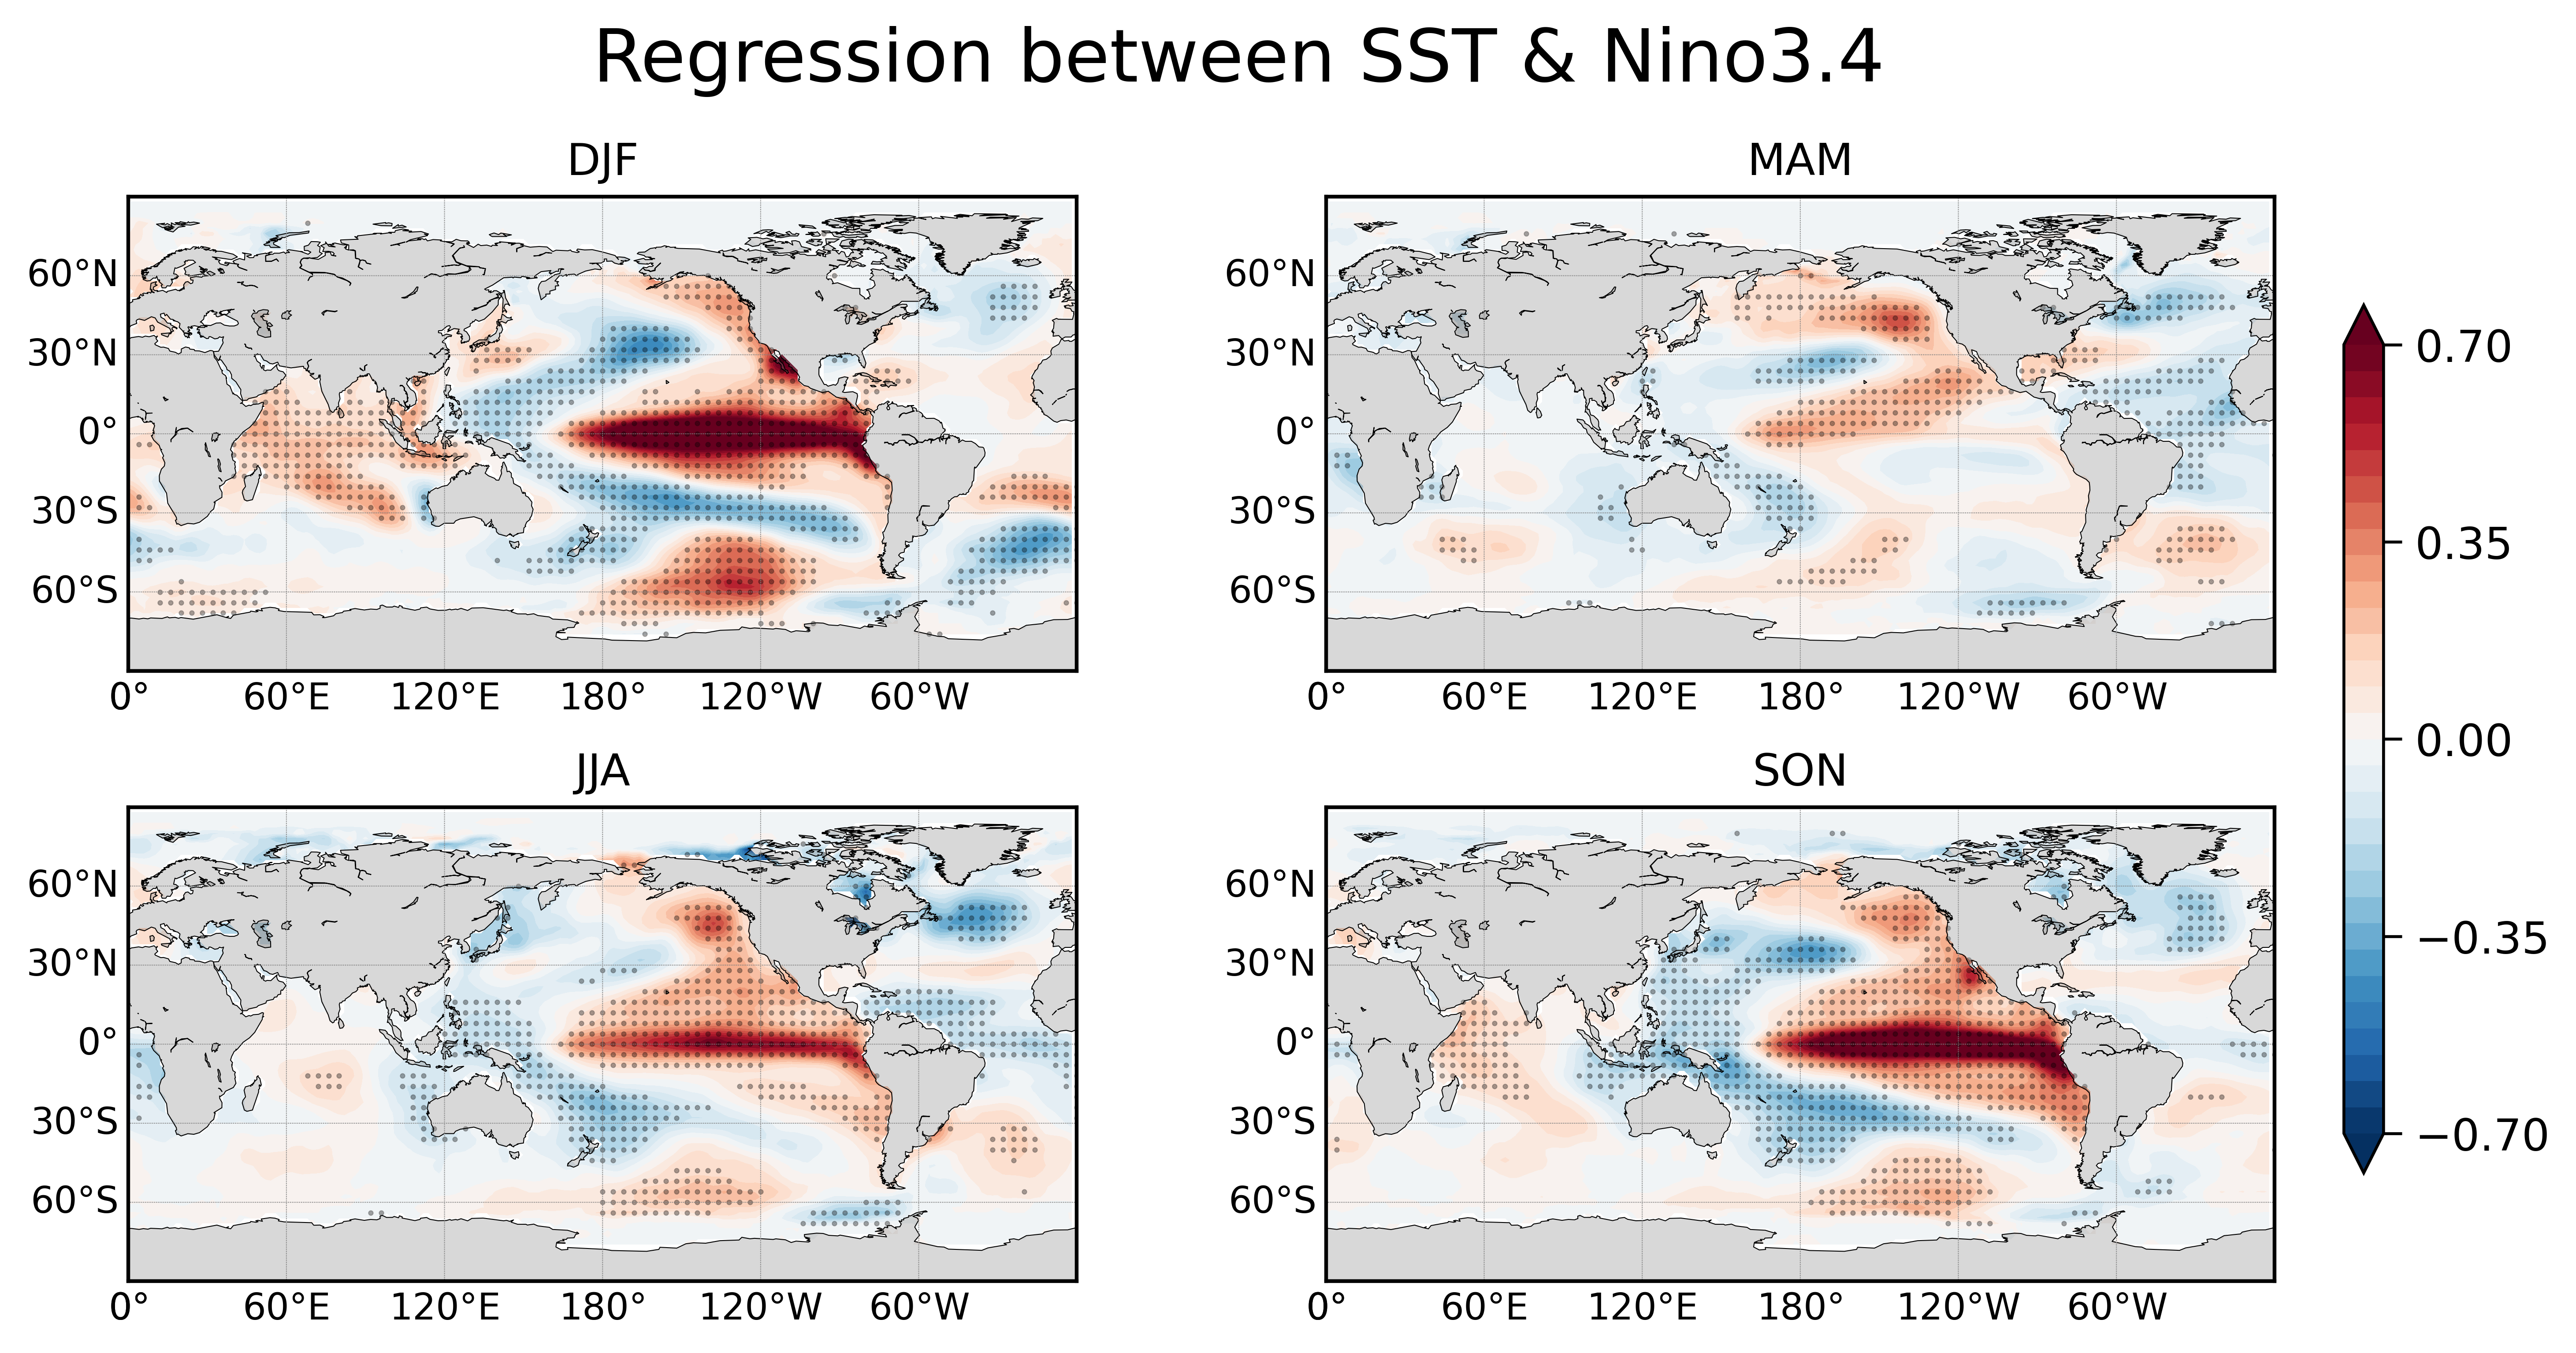

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10,5), constrained_layout = True )
season = ["DJF","MAM","JJA","SON"]

for sea in range(4):
    ind_x = sea//2 #나누기 연산 후 소수점 이하의 수를 버리고, 정수 부분의 수만 구함
    ind_y = sea%2  #나누기 연산 후 몫이 아닌 나머지를 구함
    
    if (season[sea]=="DJF"):
        SST_season_all = anom_SST.where(anom_SST['time.season'] == 'DJF')
        SST_season    = SST_season_all.rolling(min_periods=3, center=True, time=3).mean()
        SST_season[0] = SST_season_all[0:2].mean()
        SST_season = SST_season.groupby('time.year').mean('time')
        SST_season = SST_season[1::]
    else:
        SST_season_all = anom_SST.where(anom_SST['time.season'] == season[sea])
        SST_season = SST_season_all.groupby('time.year').mean('time')
        SST_season = SST_season[0:-1]
        
    ## Calclate correlation(DJF SST, DJF nino34)

    n_dims = SST_season.shape
    reg = np.empty([n_dims[1],n_dims[2]])
    intercept = np.empty([n_dims[1],n_dims[2]])
    r_value = np.empty([n_dims[1],n_dims[2]])
    p_value = np.empty([n_dims[1],n_dims[2]])
    std_err = np.empty([n_dims[1],n_dims[2]])

    for i in range(n_dims[1]):
        for j in range(n_dims[2]):
            logic = np.logical_and( ~np.isnan(nino34.values[1::]), ~np.isnan(SST_season.values[:,i,j]) )
            if np.sum(logic) >= 39:
                reg[i,j], intercept[i,j], r_value[i,j], p_value[i,j], std_err[i,j] = stats.linregress( nino34.values[1::], SST_season.values[:,i,j] )
            else:
                reg[i,j], intercept[i,j], r_value[i,j], p_value[i,j], std_err[i,j] = np.nan, np.nan, np.nan, np.nan, np.nan

    ## Plot correlation contour map
    cmap         = plt.get_cmap('RdBu_r')
    pval_sig_lev = 0.05
    lon0         = -180

    m = Basemap(projection = 'cyl', lon_0 = lon0, resolution = 'c', ax = axes[ind_x][ind_y])
    m.fillcontinents(color = 'grey',lake_color = 'grey', alpha = 0.3)
    m.drawcoastlines(linewidth = 0.25)
    m.drawmapboundary(fill_color = 'white')
    m.drawparallels(np.arange(-60.,61.,30.),labels = [1,0,0,0], color = 'grey',linewidth=0.25)
    m.drawmeridians(np.arange(-180.,181.,60.),labels = [0,0,0,1], color = 'grey',linewidth=0.25)

    contour_shifted, lon_shifted = shiftgrid(180+lon0, reg, lon, start = False, cyclic=360)
    lon_new, lat_new = np.meshgrid(lon_shifted,lat)
    x, y = m(lon_new,lat_new)
    vmin = -0.7 ; vmax = 0.7
    nv = 30 ; levels = np.linspace(vmin,vmax,nv+1)
    plot = m.contourf(x, y, contour_shifted, cmap = cmap, levels = levels, extend = 'both')

    ## Plot significant regions by dots
    lat_signi = []; lon_signi = []
    for i in range(0,len(lat),2):
        for j in range(0,len(lon),2):
            if (p_value[i,j] < pval_sig_lev):
                lat_signi.append(lat[i])
                lon_signi.append(lon[j])
    x, y = m(lon_signi,lat_signi)
    m.scatter( x, y, s = 0.8, marker = '.', color = 'black', alpha = 0.4, latlon = True )
    axes[ind_x][ind_y].set_title(season[sea])

## Detail plot properties    
cbar = fig.colorbar(plot, location = 'right', ax = axes, shrink = 0.80, aspect = 35, pad = 0.02 )
cbar.set_ticks([-0.70,-0.35,0.0,0.35,0.70])
cbar.ax.tick_params( length = 5, labelsize = 12 )

fig.suptitle("Regression between SST & Nino3.4",fontsize=20)

## <Save Regression Map Figure to RESULT directory
dir_name   =  "./"
file_name  =  "Map_Reg_Nino34_SST.pdf"
path_name  =  dir_name+file_name
plt.savefig(path_name)